In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install remotezip tqdm opencv-python einops
# !pip install -U tensorflow keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.0 MB/s eta 0:00:00


In [ ]:
import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers

In [ ]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import os

In [ ]:
ni=0
data=[]

In [ ]:


def load_videos_and_labels(video_dir, csv_path, num_frames=50, frame_size=(224, 224)):
    """
    Loads videos, extracts frames, and matches them with labels from a CSV file.

    Args:
        video_dir (str): Path to the directory containing video files.
        csv_path (str): Path to the CSV file containing video filenames and labels.
        num_frames (int): Number of frames to extract per video.
        frame_size (tuple): Resize frames to this size (height, width).

    Returns:
        A list of tuples (frames, label), where:
        - frames: Tensor of shape (num_frames, frame_height, frame_width, 3).
        - label: Corresponding label for each set of frames.
    """
    print('new callll')
    # Load labels from CSV
    df = pd.read_csv(csv_path)

    # List to store each set of frames and its label
    # for _, row in df.iterrows():
    for i in range(500):
        # video_path = os.path.join(video_dir, row['File Name'])
        x1=None
        global ni
        # x1=df.iloc(ni+i)
        try:
          x1=df.iloc[ni]
        except:
          print('ohho')
          return
        print(type(x1))
        print('Video:',x1['File Name'])
        video_path=os.path.join(video_dir,x1['File Name'])

        label = x1['Class']
        # print('Video:',x1['File Name'])

        # Capture the video
        cap = cv2.VideoCapture(video_path)
        frames = []

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)

        for idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if not ret:
                break
            # Resize the frame
            frame = cv2.resize(frame, frame_size)
            # Convert BGR to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)


        cap.release()

        if len(frames) == num_frames:
            frames = np.array(frames, dtype=np.float32) / 255.0  # Normalize frames
            global data
            data.append((frames, label))

        ni+=1
    return


In [ ]:
# Example usage:
video_dir = 'drive/MyDrive/normal'
csv_path = 'drive/MyDrive/datasheet_new.csv'
load_videos_and_labels(video_dir, csv_path)

new callll
<class 'pandas.core.series.Series'>
Video: Normal_000001.mp4
<class 'pandas.core.series.Series'>
Video: Crash_000001.mp4
<class 'pandas.core.series.Series'>
Video: Normal_000002.mp4
<class 'pandas.core.series.Series'>
Video: Crash_000002.mp4
<class 'pandas.core.series.Series'>
Video: Normal_000003.mp4
<class 'pandas.core.series.Series'>
Video: Crash_000003.mp4
<class 'pandas.core.series.Series'>
Video: Normal_000004.mp4
<class 'pandas.core.series.Series'>
Video: Crash_000004.mp4
<class 'pandas.core.series.Series'>
Video: Normal_000005.mp4
<class 'pandas.core.series.Series'>
Video: Crash_000005.mp4
<class 'pandas.core.series.Series'>
Video: Normal_000006.mp4
<class 'pandas.core.series.Series'>
Video: Crash_000006.mp4
<class 'pandas.core.series.Series'>
Video: Normal_000007.mp4
<class 'pandas.core.series.Series'>
Video: Crash_000007.mp4
<class 'pandas.core.series.Series'>
Video: Normal_000008.mp4
<class 'pandas.core.series.Series'>
Video: Crash_000008.mp4
<class 'pandas.core.s

In [ ]:
# Define the generator function
def generator():
    for frames, label in data:
        yield frames, label

# Define the output signature
output_signature = (
    tf.TensorSpec(shape=(50, 224, 224, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(), dtype=tf.int16)
)

# Create the dataset from the generator
dataset = tf.data.Dataset.from_generator(
    generator,
    output_signature=output_signature
).shuffle(buffer_size=100)

# Calculate the train and test sizes
dataset_size = len(data)
train_size = int(dataset_size * 0.7)
val_size=int(dataset_size*0.1)
print('val_size:',val_size)
# Split the dataset before batching
train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size+val_size)
val_ds=dataset.take(val_size)
print('train_size:',train_size)
print('test_size:',dataset_size-val_size-train_size)
# Batch the datasets
batch_size = 8
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
# Print the sizes for debugging
print(f"\nTrain dataset size: {len(list(train_ds))}")
print(f"Validation dataset size: {len(list(val_ds))}")
print(f"Test dataset size: {len(list(test_ds))}")


val_size: 50
train_size: 350
test_size: 100

Train dataset size: 44
Validation dataset size: 7
Test dataset size: 13


In [ ]:
# ni2=0
# for d in dataset:
#   # print(d)
#   ni2+=1
# ni2
ni2=ni//8

In [ ]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [ ]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension.
    """
    super().__init__()
    self.seq = keras.Sequential([
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)

In [ ]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [ ]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different
    sized filters and downsampled.
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

In [ ]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters,
                     kernel_size)(input)

  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

In [ ]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.

      Args:
        video: Tensor representation of the video, in the form of a set of frames.

      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height,
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

In [ ]:
input_shape = (None, 50, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(1,activation='sigmoid')(x)

model = keras.Model(input, x)

In [ ]:
frames, label = next(iter(train_ds))
model.build(frames)

In [ ]:
!pip uninstall pydot

In [ ]:
# Visualize the model
!pip install pydot
!pip install graphviz
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.9 MB/s eta 0:00:00
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
import time
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# Define the model checkpoint callback
checkpoint = ModelCheckpoint(
    filepath='drive/MyDrive/(2+1)D_weights_new.keras',  # Save the model with the highest val accuracy
    monitor='accuracy',      # Monitor the validation binary accuracy
    save_best_only=True,                # Save only the best model
    mode='max',                         # We want to maximize the validation accuracy
    verbose=1
)

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    verbose=1,  # Prints a message when training stops
    restore_best_weights=True  # Restores the model weights from the epoch with the best value of the monitored quantity
)


In [ ]:
history = model.fit(x = train_ds,
                    epochs = 10,
                    validation_data = val_ds,
                    callbacks=[checkpoint,early_stopping]
                    )

Epoch 1/10
     44/Unknown - 3381s 77s/step - loss: 0.6415 - accuracy: 0.6771
Epoch 1: accuracy improved from -inf to 0.67714, saving model to drive/MyDrive/(2+1)D_weights_new.keras
44/44 [==============================] - 3606s 82s/step - loss: 0.6415 - accuracy: 0.6771 - val_loss: 0.5618 - val_accuracy: 0.7800
Epoch 2/10
44/44 [==============================] - ETA: 0s - loss: 0.5368 - accuracy: 0.7314  
Epoch 2: accuracy improved from 0.67714 to 0.73143, saving model to drive/MyDrive/(2+1)D_weights_new.keras
44/44 [==============================] - 3589s 82s/step - loss: 0.5368 - accuracy: 0.7314 - val_loss: 0.5553 - val_accuracy: 0.7000
Epoch 3/10
44/44 [==============================] - ETA: 0s - loss: 0.5203 - accuracy: 0.7429  
Epoch 3: accuracy improved from 0.73143 to 0.74286, saving model to drive/MyDrive/(2+1)D_weights_new.keras
44/44 [==============================] - 3583s 81s/step - loss: 0.5203 - accuracy: 0.7429 - val_loss: 0.5654 - val_accuracy: 0.7800
Epoch 4/10
44/44

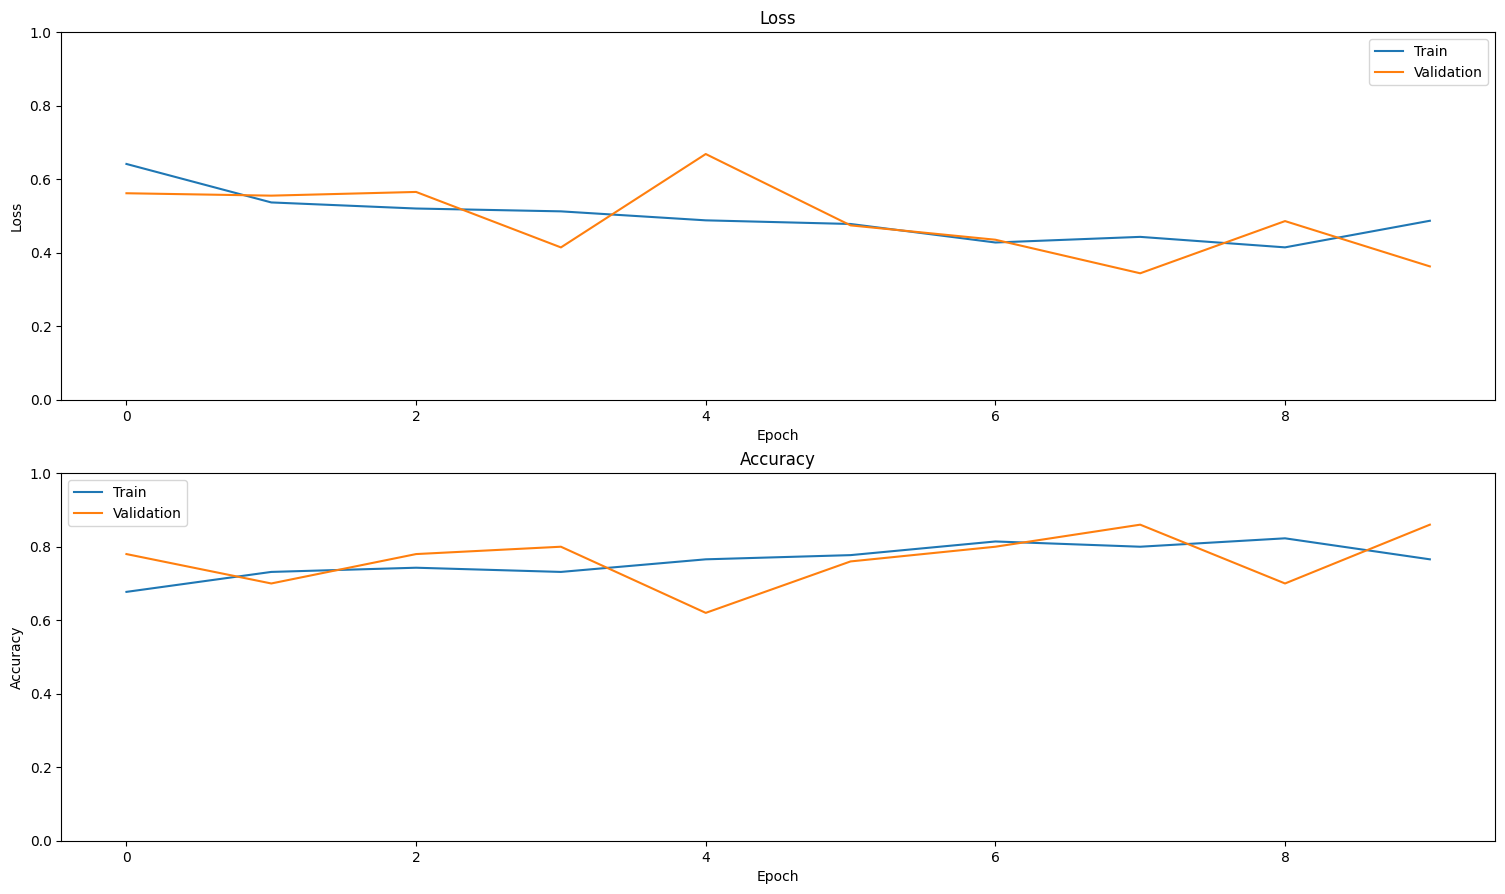

In [ ]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

In [ ]:
y_pred=model.predict(test_ds)

13/13 [==============================] - 316s 23s/step


In [ ]:
y_pred

array([[0.07495651],
       [0.0934183 ],
       [0.8680491 ],
       [0.98133373],
       [0.07560518],
       [0.9236422 ],
       [0.11730834],
       [0.8826761 ],
       [0.77282405],
       [0.0683509 ],
       [0.12193216],
       [0.75388163],
       [0.4122418 ],
       [0.9930173 ],
       [0.8239566 ],
       [0.13634227],
       [0.281991  ],
       [0.08108254],
       [0.09702732],
       [0.07422636],
       [0.22269398],
       [0.0731163 ],
       [0.4877198 ],
       [0.09370056],
       [0.34185946],
       [0.11774119],
       [0.07043974],
       [0.07941536],
       [0.25746942],
       [0.07115015],
       [0.20772128],
       [0.88021964],
       [0.7619196 ],
       [0.9570225 ],
       [0.90356255],
       [0.6899252 ],
       [0.99947953],
       [0.3296086 ],
       [0.9900778 ],
       [0.20977627],
       [0.34752268],
       [0.93632144],
       [0.10617593],
       [0.33304942],
       [0.97676873],
       [0.23627166],
       [0.791682  ],
       [0.775

In [ ]:
# print(test_ds[0][1])
y_actual=[]
_l_=[]
for t in test_ds:
  print(t[1])
  _l_+=list(t[1])


tf.Tensor([1 0 0 0 0 0 0 1], shape=(8,), dtype=int16)
tf.Tensor([1 0 0 1 0 0 1 0], shape=(8,), dtype=int16)
tf.Tensor([1 1 0 1 0 1 1 0], shape=(8,), dtype=int16)
tf.Tensor([1 1 1 0 1 1 0 1], shape=(8,), dtype=int16)
tf.Tensor([0 1 1 0 1 0 0 0], shape=(8,), dtype=int16)
tf.Tensor([1 0 0 0 0 0 1 1], shape=(8,), dtype=int16)
tf.Tensor([0 1 0 0 0 1 1 1], shape=(8,), dtype=int16)
tf.Tensor([1 0 0 1 0 1 1 0], shape=(8,), dtype=int16)
tf.Tensor([1 1 1 0 1 1 0 1], shape=(8,), dtype=int16)
tf.Tensor([1 0 0 0 1 0 1 0], shape=(8,), dtype=int16)
tf.Tensor([1 0 0 1 1 1 1 1], shape=(8,), dtype=int16)
tf.Tensor([0 1 1 1 0 0 1 0], shape=(8,), dtype=int16)
tf.Tensor([0 1 0 1], shape=(4,), dtype=int16)


In [ ]:
_l_=[int(e) for e in _l_]

In [ ]:
len(_l_)

100

In [ ]:
_l_

[1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1]

In [ ]:
y_actual=_l_

In [ ]:
y_actual

[1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1]

In [ ]:
y_pred.flatten()

array([0.07495651, 0.0934183 , 0.8680491 , 0.98133373, 0.07560518,
       0.9236422 , 0.11730834, 0.8826761 , 0.77282405, 0.0683509 ,
       0.12193216, 0.75388163, 0.4122418 , 0.9930173 , 0.8239566 ,
       0.13634227, 0.281991  , 0.08108254, 0.09702732, 0.07422636,
       0.22269398, 0.0731163 , 0.4877198 , 0.09370056, 0.34185946,
       0.11774119, 0.07043974, 0.07941536, 0.25746942, 0.07115015,
       0.20772128, 0.88021964, 0.7619196 , 0.9570225 , 0.90356255,
       0.6899252 , 0.99947953, 0.3296086 , 0.9900778 , 0.20977627,
       0.34752268, 0.93632144, 0.10617593, 0.33304942, 0.97676873,
       0.23627166, 0.791682  , 0.7750905 , 0.12712134, 0.9767516 ,
       0.5991165 , 0.06370877, 0.9503321 , 0.16498807, 0.33727196,
       0.069538  , 0.3108676 , 0.0751019 , 0.07336053, 0.07280816,
       0.99581   , 0.9614535 , 0.21468507, 0.52386415, 0.11020581,
       0.18984827, 0.9965971 , 0.8011745 , 0.3025222 , 0.7319619 ,
       0.14734803, 0.0720695 , 0.07980017, 0.5415489 , 0.06750

In [ ]:
y_pred_binary=[(e>=0.5) for e in y_pred]
tmpp=[]
for val in y_pred_binary:
  if(val):
    tmpp.append(1)
  else:
    tmpp.append(0)
y_pred_binary=tmpp

In [ ]:
y_pred_binary

[0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1]

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_actual,y_pred_binary)

0.48

In [ ]:
model.save('drive/MyDrive/mymodel.keras')
model.save('mymodel.keras')

In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
import tensorflow as tf
model_final=tf.keras.models.load_model('drive/MyDrive/mymodel.keras',custom_objects={'Conv2Plus1D':Conv2Plus1D,'ResizeVideo':ResizeVideo,'Project':Project,'ResidualMain':ResidualMain,'add_residual_block':add_residual_block})

In [ ]:
model_final.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 224, 224, 3)]    0         []                            
                                                                                                  
 conv2_plus1d_2 (Conv2Plus1  (None, 50, 224, 224, 16)     3152      ['input_1[0][0]']             
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 50, 224, 224, 16)     64        ['conv2_plus1d_2[0][0]']      
 Normalization)                                                                                   
                                                                                              

In [ ]:
weights_final=model_final.load_weights('drive/MyDrive/(2+1)D_weights_new.keras')

In [ ]:
model_final.save('drive/MyDrive/dashing_model.keras')